In [1]:
import numpy as np
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import copy

api = wandb.Api()
entity, project = "claire-labo", "pack"
task = "flatpack"
num_models = 1
sweep_specifier = "arxiv"
max_round_num = 2700 
linewidth = 3

llama32best = "s2"
qwensmallbest = "s0"
granitebest = "s2"
phibest = "s2"
prefix = "finalarxiv"

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')

legend_name_map = {
    # "qwensmall-s0": "Qwen - EvoTune",
    # "qwensmall-b": "Qwen - FunSearch",
    "llama32-s2": "Llama - EvoTune",
    "llama32-b": "Llama - FunSearch",
    "granite-s2": "Granite - EvoTune", 
    "granite-b": "Granite - FunSearch",
    "phi-s2": "Phi - EvoTune",
    "phi-b": "Phi - FunSearch",
}


color_map = {
    "llama32":   "#76B7B2",  # Blue "#76B7B2"
    "phi":       "#F28E2B",  # Orange
    "granite":   "#E15759",  # Red
    "qwensmall": "#4E79A7",  # Teal
}


font_family = 'Times New Roman'  # Change to desired font

line_style_map = {
    "b": "dotted",
    "s0": "solid",
    "s2": "solid",
}

In [3]:
metric_key = "avg_passed_true_score"

results = {
    # "qwensmall":{qwensmallbest:[], "b":[]}, 
    "granite":{granitebest:[], "b":[]}, 
    "phi":{phibest:[], "b":[]},
    "llama32":{llama32best:[], "b":[]},        
    }


for model_name in results.keys():
    for sweep_identifier in results[model_name].keys():
        #model_name = "llama32"
        #sweep_identifier = "b" # "b", "s0", "s1", "s2""
        filters = {"config.config_specific": f"{num_models}m{model_name}{sweep_specifier}{sweep_identifier}"
                    , "config.task_name": task, "config.prefix": prefix} # "config.config_specific": "1llama32icmlb"
        runs = api.runs(entity + "/" + project, filters=filters)

        seeds = []
        for run in runs:
            if run.metadata["program"].endswith("eval.py"):
                continue
            print(run.name)
            seeds.append(run.config["seed"])
        seeds = list(set(seeds))

        histories = {}.fromkeys(seeds)
        histories = {seed: [] for seed in seeds}
        keys = [metric_key, "round_num"]
        for run in runs:
            if run.metadata["program"].endswith("eval.py"):
                continue
            # history = run.scan_history(keys=keys)
            history = run.history(keys=keys, pandas=True, samples=100, x_axis='round_num')
            s = run.config["seed"]
            histories[s].append(history)

        for seed in seeds:
            histories[seed] = copy.deepcopy([history for history in histories[seed] if not history.empty])
            # check if there are any duplicates, if there are drop the first row with the duplicate round_num
            for history in histories[seed]:
                history.drop_duplicates(subset="round_num", keep="last", inplace=True)
            assert all(histories[seed][i]["round_num"].duplicated().sum() == 0 for i in range(len(histories[seed]))), f"Seed {seed} has duplicates"

        for seed in seeds:
            histories[seed] = pd.concat(histories[seed]).reset_index(drop=True)
            histories[seed] = histories[seed].drop_duplicates(subset=["round_num"], keep="first").reset_index(drop=True)

        metrics = {}.fromkeys(keys)
        metrics = {key: [] for key in keys}

        for seed, history_df in histories.items():
            for key in keys:
                metrics[key].append(history_df[key].tolist())

        results[model_name][sweep_identifier] = metrics


# Average metrics over seeds and plot all in one figure
plt.figure(figsize=(10, 6))
averaged_metrics = {}

for model_name in results.keys():
    for sweep_identifier, metrics in results[model_name].items():
        round_nums = metrics["round_num"][0]
        unique_scores = metrics[metric_key]

        # Truncate based on max_round_num and exclude round_num == -1
        truncated_rounds = [rn for rn in round_nums if rn <= max_round_num ]
        truncated_unique_scores = [
            [score for rn, score in zip(metrics["round_num"][seed], unique_scores[seed]) if rn <= max_round_num]
            for seed in range(len(metrics["round_num"]))
        ]
        
        # Calculate average and standard error
        averaged = np.mean(truncated_unique_scores, axis=0)
        std_error = np.std(truncated_unique_scores, axis=0) / np.sqrt(len(truncated_unique_scores))
        
        # To fix the issue of the first round being -1
        truncated_rounds = truncated_rounds[1:]
        truncated_rounds.extend([truncated_rounds[-1] + 100])

        averaged_metrics[f"{model_name}-{sweep_identifier}"] = {
            "round_num": truncated_rounds,
            "unique_scores": averaged,
            "std_error": std_error
        }

finalarxiv/taskflatpack_1mgranitearxivs2_7
finalarxiv/taskflatpack_1mgranitearxivs2_6
finalarxiv/taskflatpack_1mgranitearxivs2_5
finalarxiv/taskflatpack_1mgranitearxivs2_2
finalarxiv/taskflatpack_1mgranitearxivs2_3
finalarxiv/taskflatpack_1mgranitearxivs2_4
finalarxiv/taskflatpack_1mgranitearxivs2_1
finalarxiv/taskflatpack_1mgranitearxivs2_0
finalarxiv/taskflatpack_1mgranitearxivs2_9
finalarxiv/taskflatpack_1mgranitearxivs2_8
finalarxiv/taskflatpack_1mgranitearxivs2_1
finalarxiv/taskflatpack_1mgranitearxivs2_0
finalarxiv/taskflatpack_1mgranitearxivs2_5
finalarxiv/taskflatpack_1mgranitearxivs2_4
finalarxiv/taskflatpack_1mgranitearxivs2_6
finalarxiv/taskflatpack_1mgranitearxivs2_7
finalarxiv/taskflatpack_1mgranitearxivs2_2
finalarxiv/taskflatpack_1mgranitearxivs2_3
finalarxiv/taskflatpack_1mgranitearxivs2_8
finalarxiv/taskflatpack_1mgranitearxivs2_9
finalarxiv/taskflatpack_1mgranitearxivs2_7
finalarxiv/taskflatpack_1mgranitearxivs2_3
finalarxiv/taskflatpack_1mgranitearxivs2_6
finalarxiv/

<Figure size 1000x600 with 0 Axes>

In [7]:
plt.figure(figsize=(10, 6))
averaged_metrics = {}

for model_name in results.keys():
    for sweep_identifier, metrics in results[model_name].items():
        round_nums = metrics["round_num"][0]
        unique_scores = metrics[metric_key]

        # Truncate based on max_round_num and exclude round_num == -1
        truncated_rounds = [rn for rn in round_nums if rn <= max_round_num ]
        truncated_unique_scores = [
            [score for rn, score in zip(metrics["round_num"][seed], unique_scores[seed]) if rn <= max_round_num]
            for seed in range(len(metrics["round_num"]))
        ]

        # replace any 'NaN' value with the mean of the first and last non-NaN values before and after it
        for scores in truncated_unique_scores:
            for i, score in enumerate(scores):
                if score == 'NaN':
                    j = i - 1
                    while scores[j] == 'NaN':
                        j -= 1
                    k = i + 1
                    while scores[k] == 'NaN':
                        k += 1
                    scores[i] = (scores[j] + scores[k]) / 2
        
        # Calculate average and standard error
        averaged = np.mean(truncated_unique_scores, axis=0)
        std_error = np.std(truncated_unique_scores, axis=0) / np.sqrt(len(truncated_unique_scores))
        
        # To fix the issue of the first round being -1
        truncated_rounds = truncated_rounds[1:]
        truncated_rounds.extend([truncated_rounds[-1] + 100])

        averaged_metrics[f"{model_name}-{sweep_identifier}"] = {
            "round_num": truncated_rounds,
            "unique_scores": averaged,
            "std_error": std_error
        }

<Figure size 1000x600 with 0 Axes>

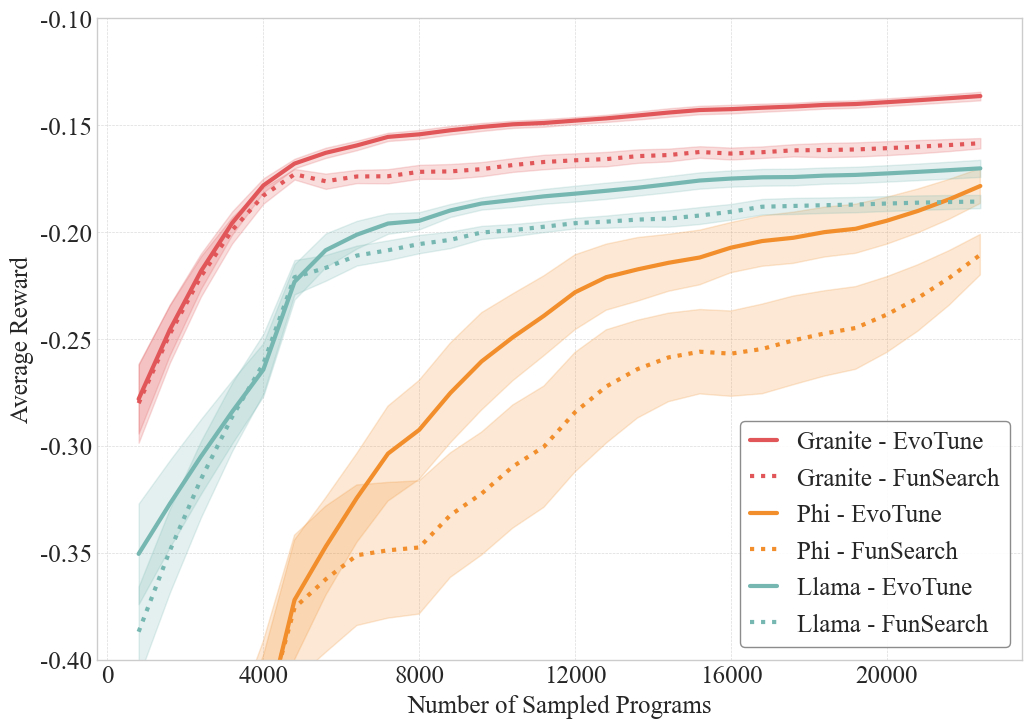

In [30]:
font_ticks = 18
font_axis = 18
figname = "avg_reward"


fig, ax = plt.subplots(figsize=(10, 7))

from scipy.signal import savgol_filter
for label, data in averaged_metrics.items():
    model, identifier = label.split('-')
    smoothed_scores = savgol_filter(data["unique_scores"], window_length=10, polyorder=2)
    smoothed_std_error = savgol_filter(data["std_error"], window_length=10, polyorder=2)
    plt.plot(
        data["round_num"],
        smoothed_scores,
        label=legend_name_map.get(label, label),
        color=color_map[model],
        linestyle=line_style_map.get(identifier, "solid"),
        linewidth=linewidth,
    )
    plt.fill_between(
        data["round_num"],
        smoothed_scores - smoothed_std_error,
        smoothed_scores + smoothed_std_error,
        color=color_map[model],
        alpha=0.2
            )

# Add a legend with a visible frame
legend = ax.legend(loc="lower right",
                   fontsize=font_ticks, 
                   frameon=True, 
                   handlelength=1.1, 
                   )
legend.get_frame().set_edgecolor("grey")  # Set frame color
legend.get_frame().set_alpha(0.9)  # Set legend transparency
for text in legend.get_texts():
    text.set_fontfamily(font_family)

# # Improve ticks and grid
ax.tick_params(axis="both", which="major", labelsize=font_ticks)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily(font_family)

# Tight layout to avoid overlap
plt.tight_layout()

# # Define a formatter function that divides the axis value by 100
def scale_formatter(x, pos):
    return f"{x/100:.1f}"

# Keep the original y-limits, so the plot itself doesn't move
# ax.set_ylim([-3000, -400])
# ax.set_xlim([-100, 2800])


# Define a formatter function that divides the axis value by 100
def scale_formatter(x, pos):
    return f"{x/100:.2f}"

# Define a formatter function that divides the axis value by 100
def x_formatter(x, pos):
    return f"{x*8:.0f}"

# Apply this formatter to the y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))
ax.xaxis.set_major_formatter(mtick.FuncFormatter(x_formatter))
# Labels and title
ax.set_xlabel("Number of Sampled Programs", fontsize=font_axis, fontfamily=font_family)
ax.set_ylabel("Average Reward", fontsize=font_axis,fontfamily=font_family)

ax.set_ylim([-40, -10])

# Save improved plot
plt.savefig(f"files/{task}_{figname}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"files/{task}_{figname}.pdf", dpi=300, bbox_inches="tight")

# Display plot
plt.show()
